In [0]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from tqdm import tqdm

In [0]:
# GPU가 있으면 GPU를 사용하고 없으면 CPU를 사용합니다.
device = torch.device("cuda:0" if torch.cuda.torch.cuda.is_available() else "cpu")

In [0]:
# 데이터 셋을 받을 때 transform할 조건을 설정합니다.
mean = 0.5
sigma = 0.5

transform = transforms.Compose([
    transforms.ToTensor(), # 데이터를 불러 올 때 Tensor 타입으로 불러옵니다.
    transforms.Normalize((mean,), (sigma,)) # 앞의 괄호는 평균, 뒤의 괄호는 표준편차이며 세 차원 모두 적용
])

In [0]:
# root경로에 train 데이터를 다운 받습니다. 이 때 조건은 transform 조건에 따라 Tensor 타입과 Normalize가 된 상태로 받습니다.
training_dataset = datasets.FashionMNIST(root = './data', train=True, download=True, transform=transform)
validation_dataset = datasets.FashionMNIST(root = './data', train=False, download=True, transform=transform)

In [0]:
training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle= True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100, shuffle=False)

In [7]:
# shape확인 (디버깅 용도)
dataiter = iter(training_loader)
images, labels = dataiter.next()
print(images.shape)

torch.Size([100, 1, 28, 28])


In [46]:
# shape확인 (디버깅 용도)
x = F.relu(nn.Conv2d(1, 20, 5)(images))
x = F.max_pool2d(x, 2, 2)
print(x.shape)
x = F.relu(nn.Conv2d(20, 50, 5)(x))
x = F.max_pool2d(x, 2, 2)
print(x.shape)

torch.Size([100, 20, 12, 12])
torch.Size([100, 50, 4, 4])


In [0]:
class LeNet(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 20, 5) # (입력 채널, 출력 채널, 필터)
        self.conv2 = nn.Conv2d(20, 50, 5)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)
        self.dropout = nn.Dropout(0.5)
        self.bn1 = nn.BatchNorm2d(20)
        self.bn2 = nn.BatchNorm2d(50)
        self.bn3 = nn.BatchNorm1d(500)
        
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = self.bn1(x)
        x = self.dropout(x)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = self.bn2(x)
        x = self.dropout(x)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.bn3(x)
        x = self.dropout(x)        
        x = self.fc2(x)
        return x
        

In [48]:
model = LeNet().to(device)
print(model)

LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.5)
  (bn1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [0]:
loss_func = nn.CrossEntropyLoss()

In [0]:
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [0]:
epochs = 20
# 학습 데이터의 loss를 저장
running_loss_history = []
# 학습 데이터의 accuracy를 저장
running_corrects_history = []
# 평가 데이터의 loss를 저장
val_running_loss_history = []
# 평가 데이터의 accuracy를 저장
val_running_corrects_history = []

In [52]:
for epoch in tqdm(range(epochs)):
    running_loss, val_running_loss = 0.0, 0.0
    running_corrects, val_running_corrects = 0.0, 0.0
    
    # 학습 데이터를 batch 단위로 가져와서 학습시킵니다.
    for inputs, labels in training_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # feedforward
        outputs = model(inputs)
        # loss를 계산합니다.
        loss = loss_func(outputs, labels)
        # gradient 초기화
        optimizer.zero_grad()
        # backpropagation
        loss.backward()
        # weight update
        optimizer.step()
        
        # output의 각 이미지 별로 class가 가장 큰 값을 가져옵니다.
        _, preds = torch.max(outputs, 1)
        
        # loss를 더해줍니다.
        running_loss += loss.item()
        # 분류가 잘 된 갯수를 더해줍니다.
        running_corrects += torch.sum(preds == labels.data)
    
    # epoch의 loss를 계산합니다.
    epoch_loss = running_loss/len(training_loader)
    running_loss_history.append(epoch_loss)
    
    # epoch의 accuracy를 계산합니다.
    epoch_acc = running_corrects/len(training_loader)
    running_corrects_history.append(epoch_acc)
    
    # 평가 데이터를 feedforward할 때에는 gradient가 필요없습니다.
    with torch.no_grad():
        for val_inputs, val_labels in validation_loader:
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.to(device)            
            
            # training 과정과 유사하나 학습이 필요없으므로 backprob하고 weight 업데이트 하는 과정이 없습니다.
            val_outputs = model(val_inputs)
            val_loss = loss_func(val_outputs, val_labels)
            
            _, val_preds = torch.max(val_outputs, 1)
            
            val_running_loss += val_loss.item()
            val_running_corrects += torch.sum(val_preds==val_labels.data)
    
    # 평가 데이터의 loss와 accuracy를 저장해줍니다.
    val_epoch_loss = val_running_loss / len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    
    val_epoch_acc = val_running_corrects / len(validation_loader)
    val_running_corrects_history.append(val_epoch_acc)
    
    # 매 epoch의 학습과 평가가 끝났으면 결과를 출력해줍니다.
    print('training loss : {:4f}, acc : {:4f}, validation loss : {:4f}, acc : {:4f}'.format(
        epoch_loss, epoch_acc, val_epoch_loss, val_epoch_acc))




  0%|          | 0/20 [00:00<?, ?it/s]


  5%|▌         | 1/20 [00:11<03:40, 11.62s/it]

training loss : 0.553966, acc : 79.000000, validation loss : 0.455683, acc : 83.000000





 10%|█         | 2/20 [00:22<03:27, 11.51s/it]

training loss : 0.415525, acc : 84.000000, validation loss : 0.433738, acc : 84.000000





 15%|█▌        | 3/20 [00:34<03:14, 11.45s/it]

training loss : 0.376946, acc : 86.000000, validation loss : 0.392344, acc : 85.000000





 20%|██        | 4/20 [00:45<03:02, 11.43s/it]

training loss : 0.357682, acc : 86.000000, validation loss : 0.376337, acc : 86.000000





 25%|██▌       | 5/20 [00:56<02:50, 11.38s/it]

training loss : 0.345590, acc : 87.000000, validation loss : 0.383547, acc : 85.000000





 30%|███       | 6/20 [01:08<02:39, 11.37s/it]

training loss : 0.333398, acc : 87.000000, validation loss : 0.360700, acc : 87.000000





 35%|███▌      | 7/20 [01:19<02:27, 11.35s/it]

training loss : 0.327142, acc : 87.000000, validation loss : 0.368794, acc : 86.000000





 40%|████      | 8/20 [01:31<02:17, 11.44s/it]

training loss : 0.317639, acc : 88.000000, validation loss : 0.359588, acc : 86.000000





 45%|████▌     | 9/20 [01:42<02:05, 11.42s/it]

training loss : 0.311847, acc : 88.000000, validation loss : 0.340023, acc : 87.000000





 50%|█████     | 10/20 [01:53<01:53, 11.40s/it]

training loss : 0.304630, acc : 88.000000, validation loss : 0.340884, acc : 87.000000





 55%|█████▌    | 11/20 [02:05<01:43, 11.48s/it]

training loss : 0.303362, acc : 88.000000, validation loss : 0.337168, acc : 87.000000





 60%|██████    | 12/20 [02:16<01:31, 11.45s/it]

training loss : 0.296985, acc : 89.000000, validation loss : 0.326767, acc : 88.000000





 65%|██████▌   | 13/20 [02:28<01:19, 11.42s/it]

training loss : 0.291332, acc : 89.000000, validation loss : 0.341927, acc : 87.000000





 70%|███████   | 14/20 [02:39<01:08, 11.39s/it]

training loss : 0.291190, acc : 89.000000, validation loss : 0.327864, acc : 88.000000





 75%|███████▌  | 15/20 [02:51<00:57, 11.45s/it]

training loss : 0.285423, acc : 89.000000, validation loss : 0.317441, acc : 88.000000





 80%|████████  | 16/20 [03:02<00:45, 11.40s/it]

training loss : 0.286080, acc : 89.000000, validation loss : 0.329730, acc : 88.000000





 85%|████████▌ | 17/20 [03:13<00:34, 11.36s/it]

training loss : 0.280773, acc : 89.000000, validation loss : 0.330931, acc : 88.000000





 90%|█████████ | 18/20 [03:25<00:22, 11.35s/it]

training loss : 0.279136, acc : 89.000000, validation loss : 0.326911, acc : 88.000000





 95%|█████████▌| 19/20 [03:36<00:11, 11.32s/it]

training loss : 0.274486, acc : 89.000000, validation loss : 0.320694, acc : 88.000000





100%|██████████| 20/20 [03:47<00:00, 11.38s/it]




training loss : 0.273703, acc : 89.000000, validation loss : 0.321750, acc : 88.000000


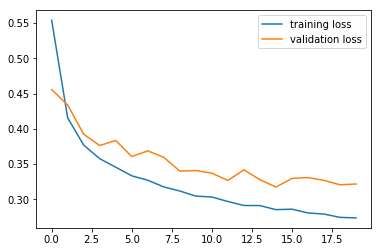

In [55]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

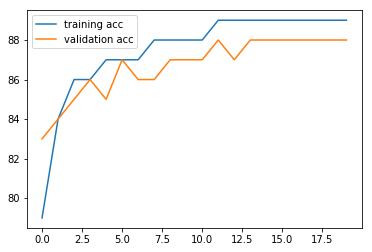

In [56]:
plt.plot(running_corrects_history, label='training acc')
plt.plot(val_running_corrects_history, label='validation acc')
plt.legend()

In [0]:
nn.BatchNorm2d